# make tfrecords dataset

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model

import numpy as np

import PIL
from PIL import Image

import time

import os

import io
from tensorflow.python.data.experimental import AUTOTUNE

import numpy as np
import matplotlib.pyplot as plt

In [2]:
def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))


#def _int64_feature(value):
#    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

#def _float_feature(list_of_floats): 
#    return tf.train.Feature(float_list=tf.train.FloatList(value=list_of_floats))

In [3]:
img_list = sorted(os.listdir('2048_1024/img/train'))
mask_list = sorted(os.listdir('2048_1024/mask/train'))

i=0
with tf.io.TFRecordWriter("pavementscape_train_2048_1024.tfrecords") as writer:
    for path, mask in zip(img_list, mask_list):
        
        image = Image.open('2048_1024/img/train/'+path)
        bytes_buffer = io.BytesIO()
        image.convert("L").save(bytes_buffer, "JPEG")
        image_bytes = bytes_buffer.getvalue()
        bytes_feature = tf.train.Feature(bytes_list=tf.train.BytesList(value=[image_bytes]))
        
        mask = np.array(Image.open('2048_1024/mask/train/'+ mask))
        mask = mask.tobytes()
        mask_feature = tf.train.Feature(bytes_list=tf.train.BytesList(value=[mask]))
        
        example = tf.train.Example(
          features=tf.train.Features(feature={
              "image": bytes_feature,
              "mask": mask_feature
          })
        )

        writer.write(example.SerializeToString())

        image.close()
        
        #i=i+1
        #if i>20:
        #    break

# How to use the Pavementscapes in the TFrecords form to train a network

In [4]:
image_feature_description = {
    "image": tf.io.FixedLenFeature([], tf.string), 
    "mask": tf.io.FixedLenFeature([], tf.string), 
    }

In [5]:
def _parse_data(unparsed_example):
    return tf.io.parse_single_example(unparsed_example, image_feature_description)

def _bytestring_to_pixels(parsed_example):
    byte_string = parsed_example['image']
    image = tf.io.decode_image(byte_string)
    image = tf.reshape(image,[1024, 2048])/255
    
    mask = tf.io.decode_raw(parsed_example['mask'], tf.uint8)
    mask = tf.reshape(mask,[1024, 2048])/30#原来的灰度图是label*30的
    mask = tf.cast(mask,tf.int32)
    mask = tf.one_hot(mask, 7)#转one hot 编码
    
    return image, mask

def load_and_extract_images(filepath):
    dataset = tf.data.TFRecordDataset(filepath)
    dataset = dataset.map(_parse_data, num_parallel_calls=AUTOTUNE)
    dataset = dataset.map(_bytestring_to_pixels, num_parallel_calls=AUTOTUNE)
    return dataset

In [8]:
dataset_test = load_and_extract_images("pavementscape_test_2048_1024.tfrecords")
dataset_val = load_and_extract_images("pavementscape_val_2048_1024.tfrecords")
dataset_train = load_and_extract_images("pavementscape_train_2048_1024.tfrecords")

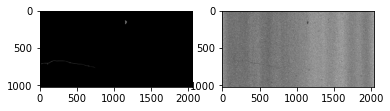

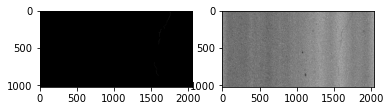

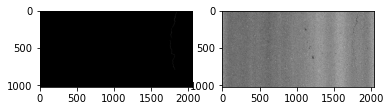

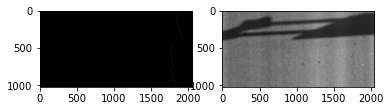

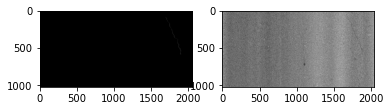

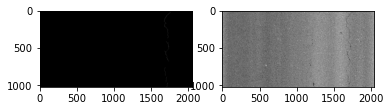

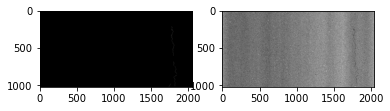

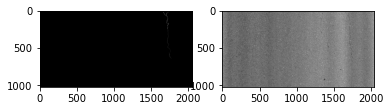

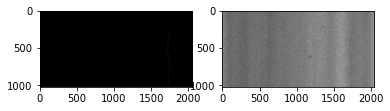

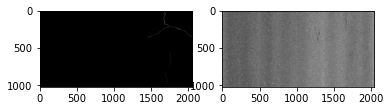

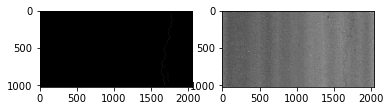

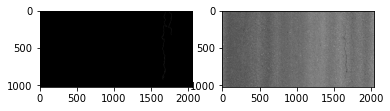

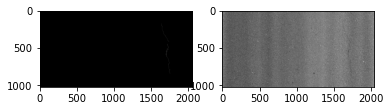

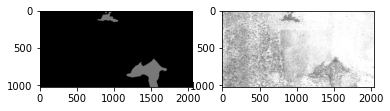

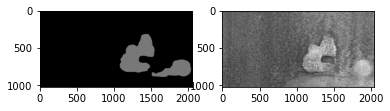

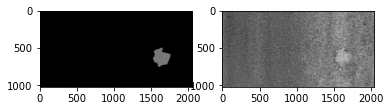

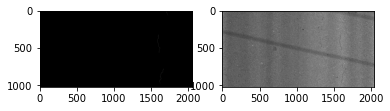

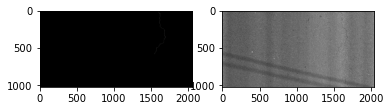

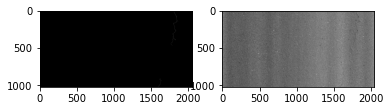

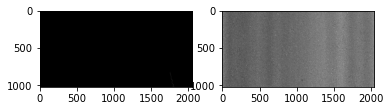

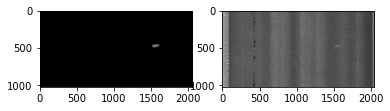

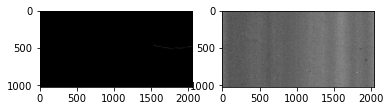

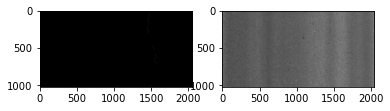

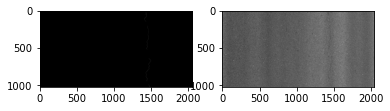

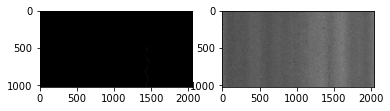

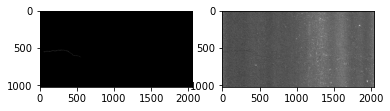

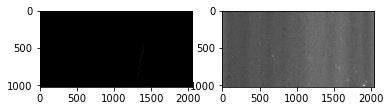

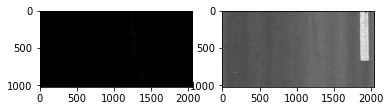

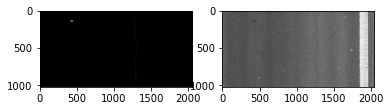

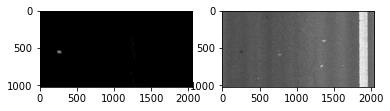

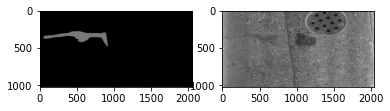

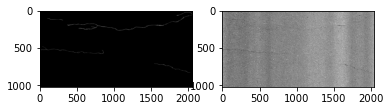

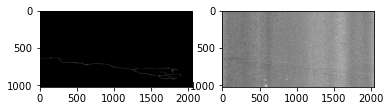

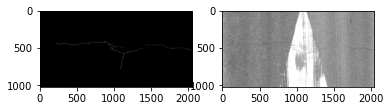

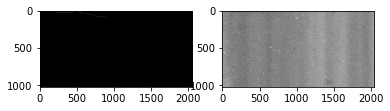

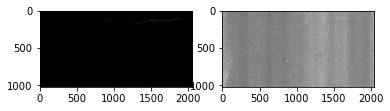

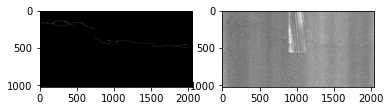

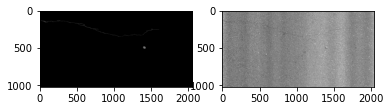

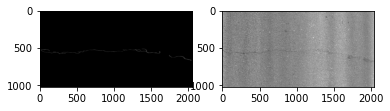

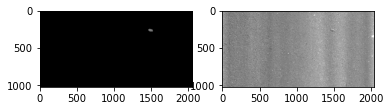

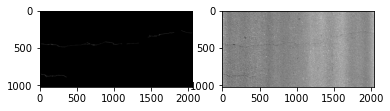

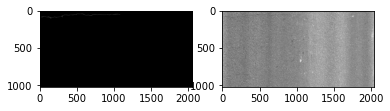

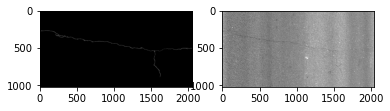

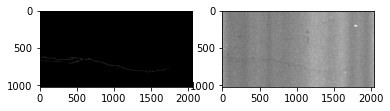

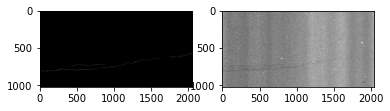

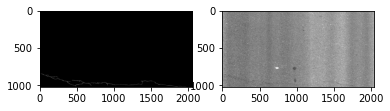

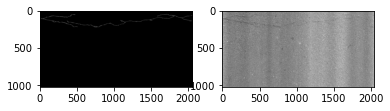

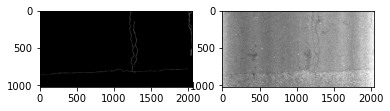

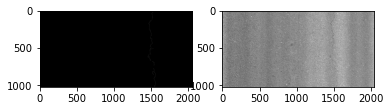

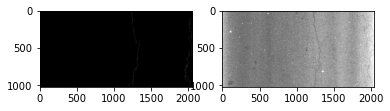

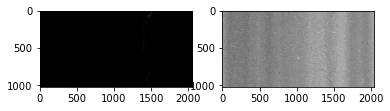

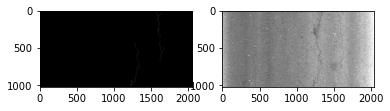

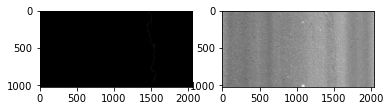

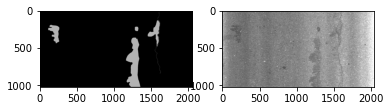

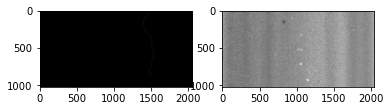

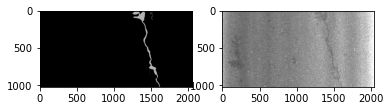

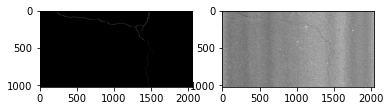

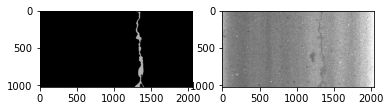

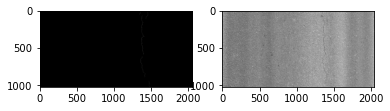

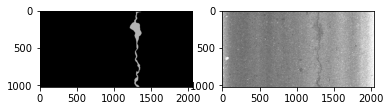

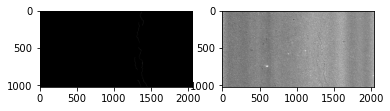

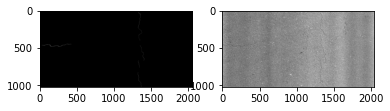

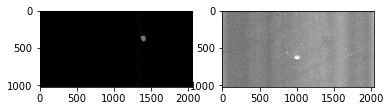

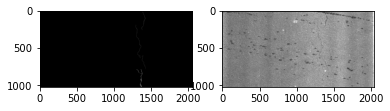

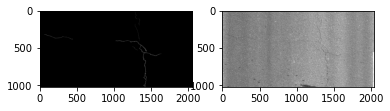

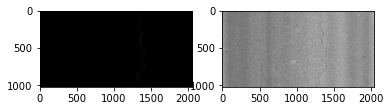

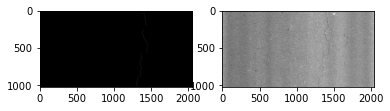

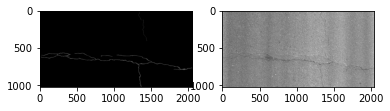

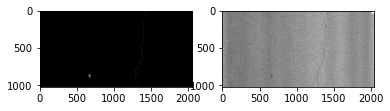

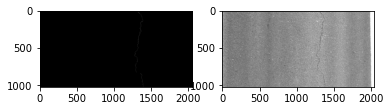

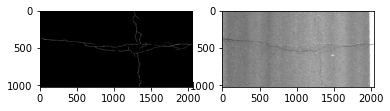

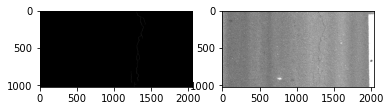

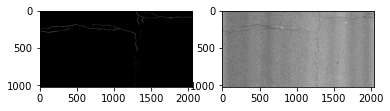

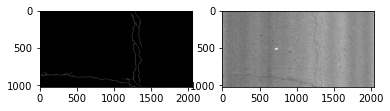

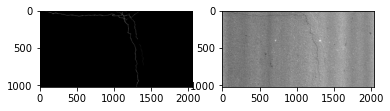

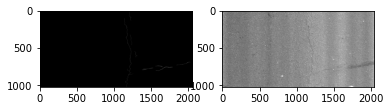

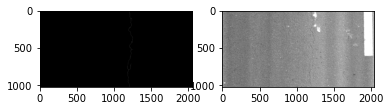

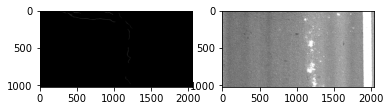

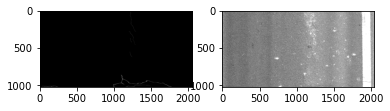

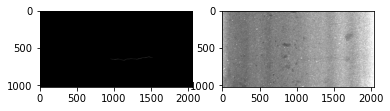

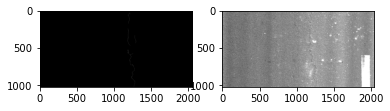

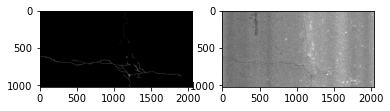

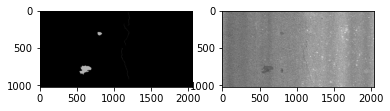

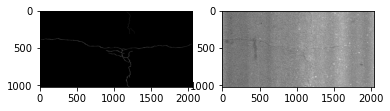

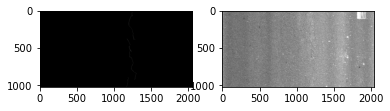

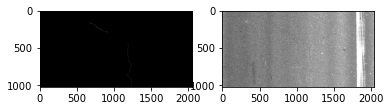

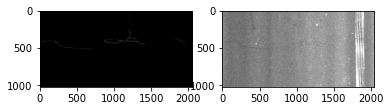

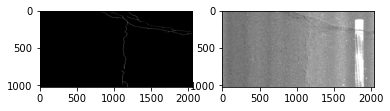

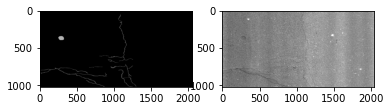

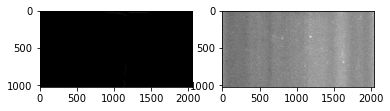

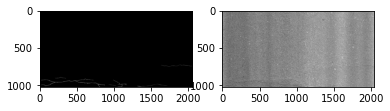

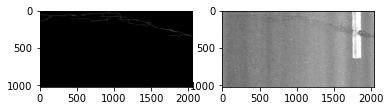

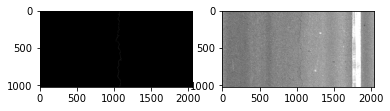

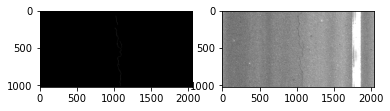

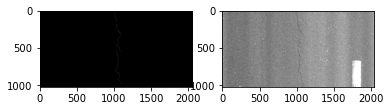

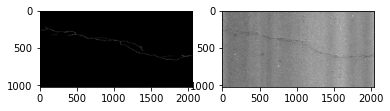

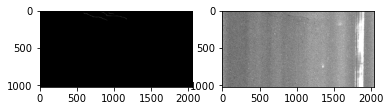

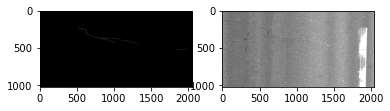

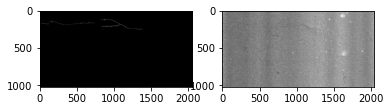

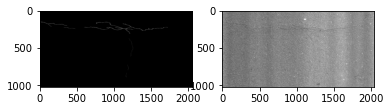

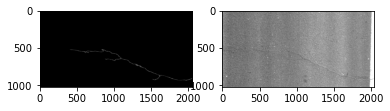

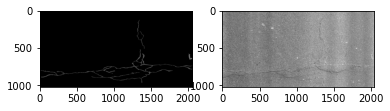

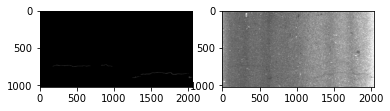

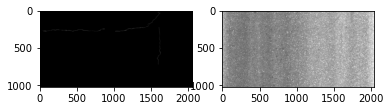

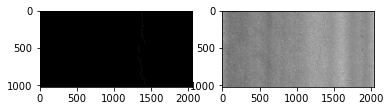

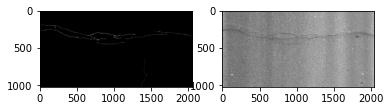

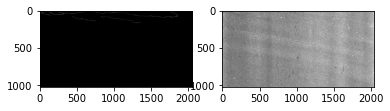

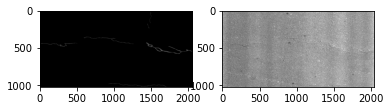

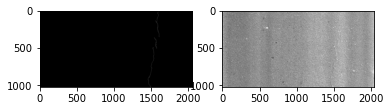

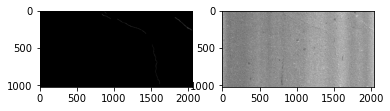

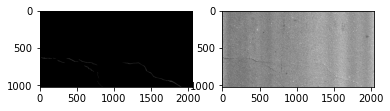

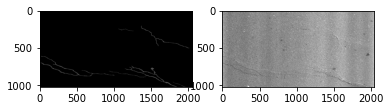

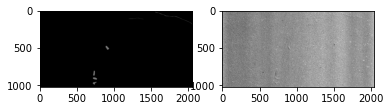

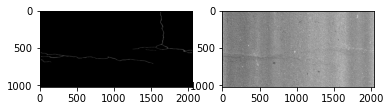

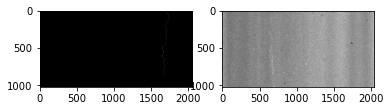

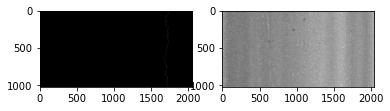

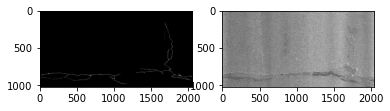

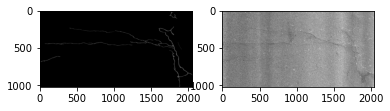

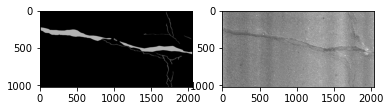

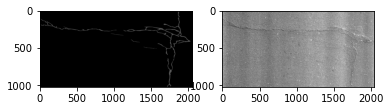

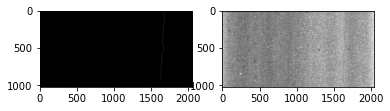

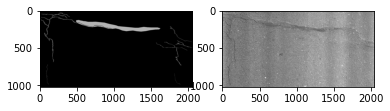

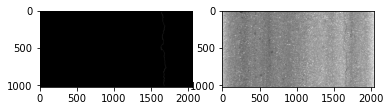

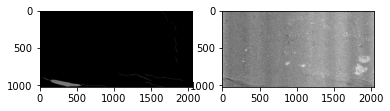

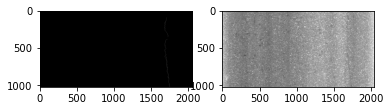

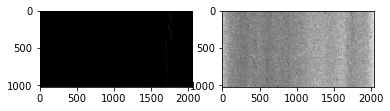

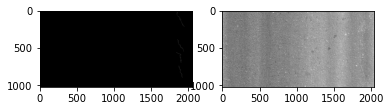

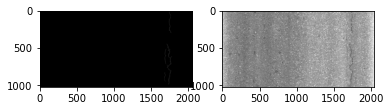

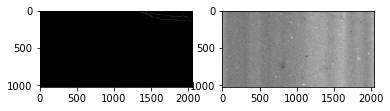

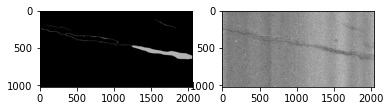

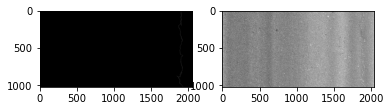

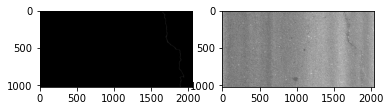

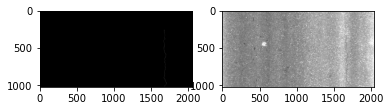

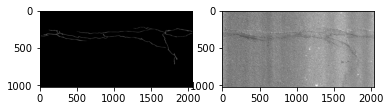

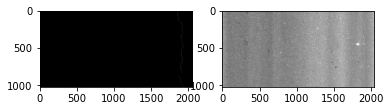

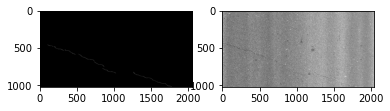

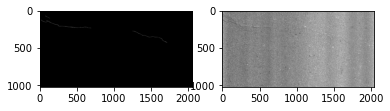

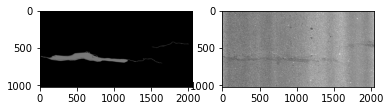

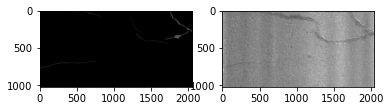

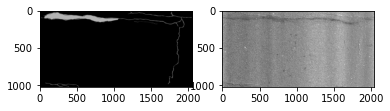

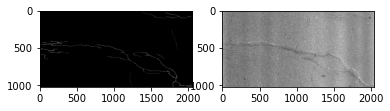

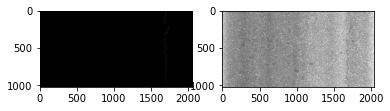

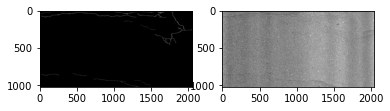

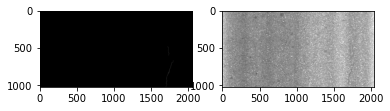

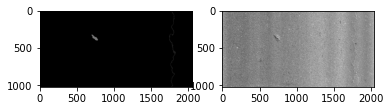

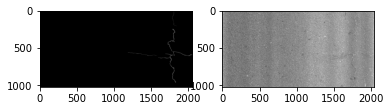

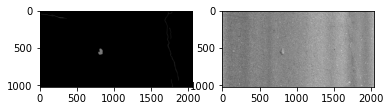

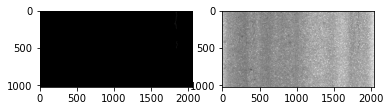

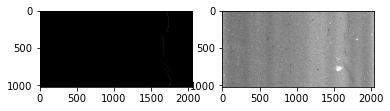

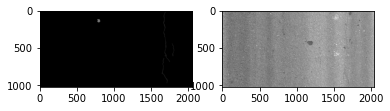

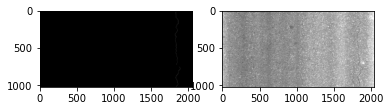

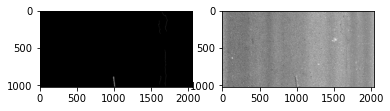

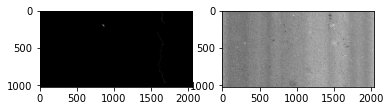

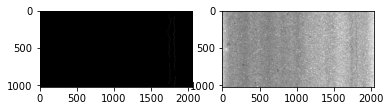

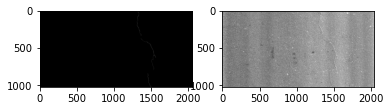

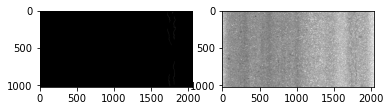

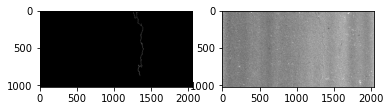

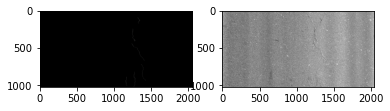

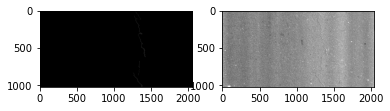

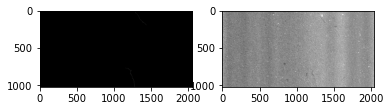

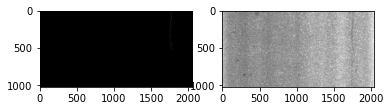

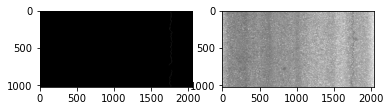

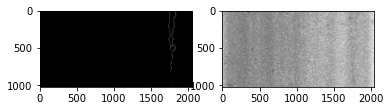

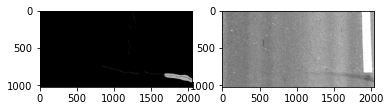

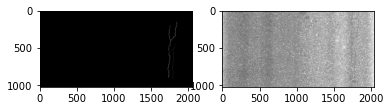

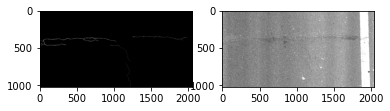

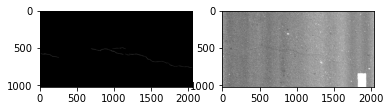

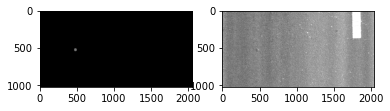

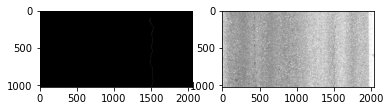

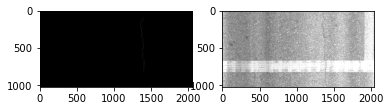

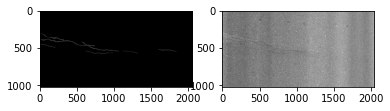

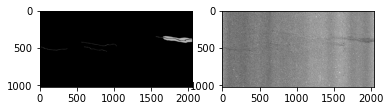

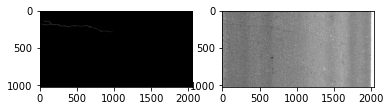

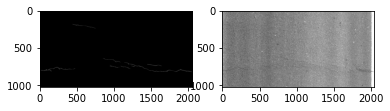

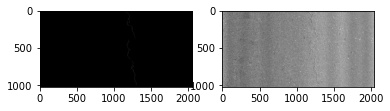

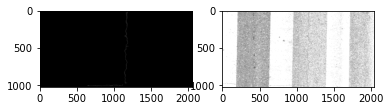

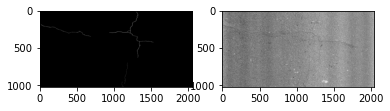

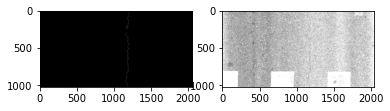

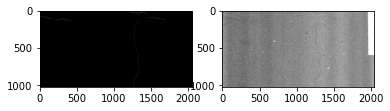

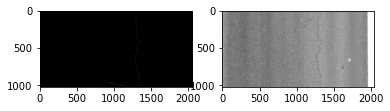

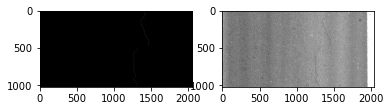

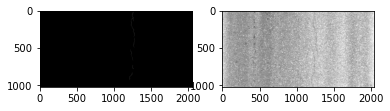

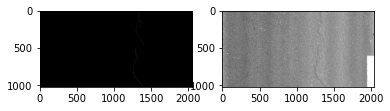

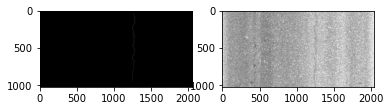

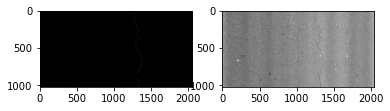

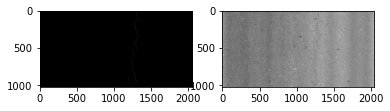

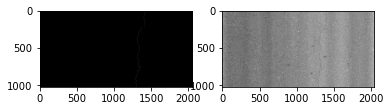

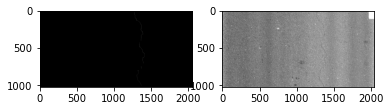

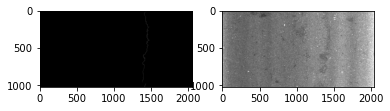

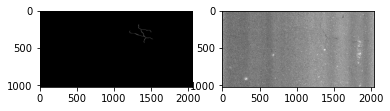

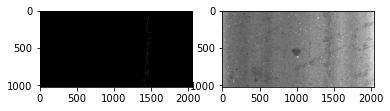

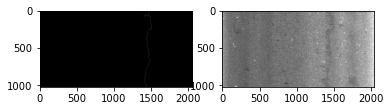

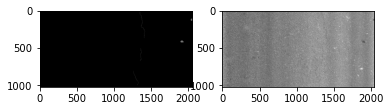

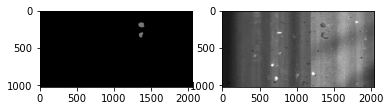

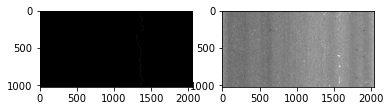

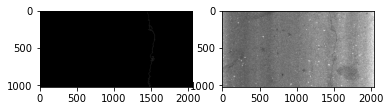

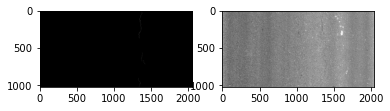

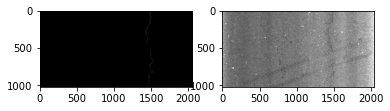

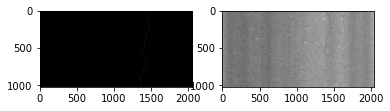

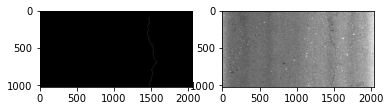

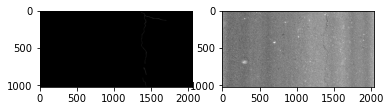

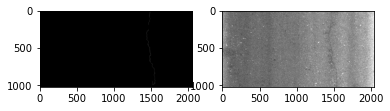

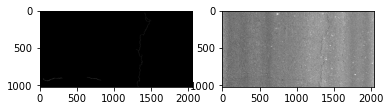

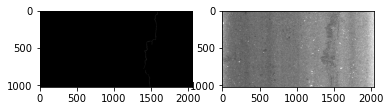

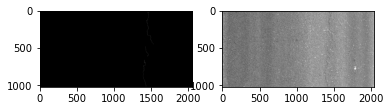

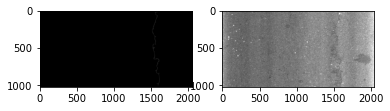

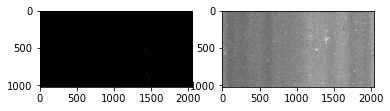

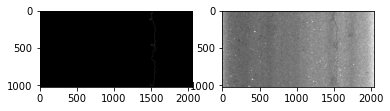

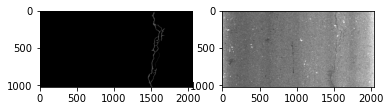

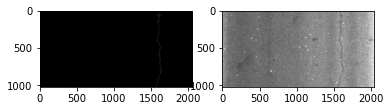

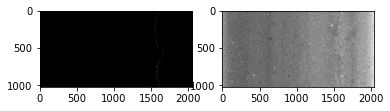

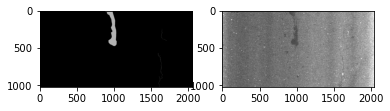

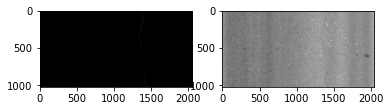

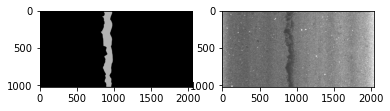

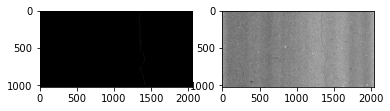

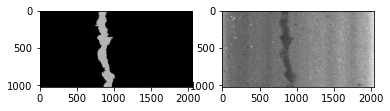

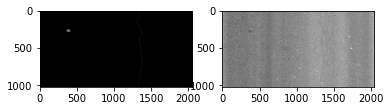

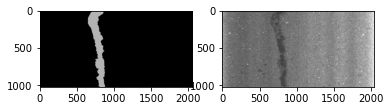

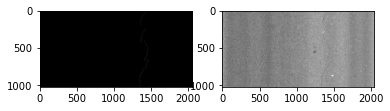

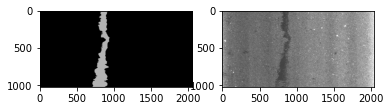

In [11]:
for img, mask in dataset_train.take(50):
    plt.subplot(1, 2, 1)
    plt.imshow(tf.argmax(mask,-1)*30, cmap='gray', vmin=0, vmax=255)
    #plt.show()
    plt.subplot(1, 2, 2)
    plt.imshow(img*255, cmap='gray', vmin=0, vmax=255)
    plt.show()

In [16]:
import tensorflow.keras as keras
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras import backend as K


def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)


def jacard_coef_loss(y_true, y_pred):
    return -jacard_coef(y_true, y_pred)  # -1 ultiplied as we want to minimize this value as loss function

Using TensorFlow backend.


In [17]:
#define a Unet for distress segmentation

IMG_WIDTH = 2048
IMG_HEIGHT = 1024
IMG_CHANNELS = 1
inputs_pixels = IMG_WIDTH * IMG_HEIGHT
num_class=6+1

inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

#Contraction path
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
 
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
 
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
 
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#Expansive path 
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
 
u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
 
u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
 
u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

outputs = tf.keras.layers.Conv2D(num_class, (1, 1), activation='sigmoid')(c9)
#outputs = tf.argmax(outputs, axis=-1)


model_ns = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model_ns.compile(optimizer='adam', loss=[jacard_coef_loss], metrics=[jacard_coef])
#model_ns.compile(optimizer='adam', 
#             loss='CategoricalCrossentropy', #MeanAbsoluteError
#             metrics=['accuracy'])
model_ns.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 1024, 2048,  0                                            
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 1024, 2048, 1 160         input_2[0][0]                    
__________________________________________________________________________________________________
dropout_9 (Dropout)             (None, 1024, 2048, 1 0           conv2d_19[0][0]                  
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 1024, 2048, 1 2320        dropout_9[0][0]                  
_______________________________________________________________________________________

In [18]:
batch_size=4#Please choose your own batch size based on your GPU menory

model_ns.fit(dataset_train.batch(batch_size), epochs=300, verbose=1, shuffle=True)

Epoch 1/300
      2/Unknown - 1s 259ms/step - loss: -0.1799 - jacard_coef: 0.1799WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0219s vs `on_train_batch_end` time: 0.2518s). Check your callbacks.
2500/2500 [==============================] - 665s 266ms/step - loss: -0.4775 - jacard_coef: 0.4775
Epoch 2/300
 678/2500 [=======>......................] - ETA: 7:39 - loss: -0.4930 - jacard_coef: 0.4930

KeyboardInterrupt: 